In [2]:
import json
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

## Accessing trained neural networks

In [3]:
#First set of dictionary keys are of the form [N, s_1, s_2, ..., s_N],
#   where N = number of layers, s_i = #nodes of layer i.
#The list of the network sizes that I trained are listed below.
network_sizes = [ (2, 36, 6), (3, 36, 36, 6),
                  (3, 36, 6, 6), (4, 36, 36, 6, 6), 
                  (4, 36, 36, 36, 6), (5, 36, 36, 36, 6, 6) 
                ]

#Regularisation parameters used for each of the neural network sizes
regularisations = [ 0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0, 10.0]

In [4]:
#The trained networks are stored in trained_networks.pkl
with open("trained_networks.pkl", "rb") as f:
    trained_networks = pkl.load(f)

def access_trainednetwork(no_layers, nodes_per_layer, regularisation):
    return trained_networks[tuple( [no_layers] + nodes_per_layer)][regularisation]

#E.g. To get trained network of 2 layers, with neurons 36, 6 and regularisation 0.05
no_layers = 2
nodes_per_layer = [36, 6]
reg = 0.05
network_data = access_trainednetwork(no_layers=no_layers, nodes_per_layer=nodes_per_layer, regularisation=reg)

#Individual network data is then accessed as below:
trained_weights, training_loss, intermediate_weights, n_epochs = ( 
    network_data["weights"],
    network_data["loss"],
    network_data["epoch_weights"],
    network_data["n_epochs"] 
    )

#Numpify weights:
trained_weights = np.asarray( trained_weights, np.float128 )
print("The weights are ")
np.set_printoptions(precision=2, suppress=True)
print( trained_weights )
print("\nThe training loss of this network is: ")
print(training_loss)
print("\nThe number of epochs of training: ")
print(n_epochs)

The weights are 
[11.66 -0.58 -0.71 -0.59 -0.58 -0.7  -0.59 -0.7  -0.51 -0.46 -0.53 -0.72
 -0.54 -0.78 -0.51 -0.63 -0.7  -0.53 -0.5  -0.66 -0.5  -0.62 -0.62 -0.62
 -0.57 -0.64 -0.48 -0.51 -0.47 -0.55 -0.54 -0.59 -0.57 -0.51 -0.6  -0.54
 -0.56  5.51 -0.28 -0.36 -0.27 -0.31 -0.47 -0.28 -0.47 -0.16 -0.22 -0.25
 -0.4  -0.26 -0.46 -0.26 -0.4  -0.43 -0.15 -0.27 -0.3  -0.2  -0.32 -0.31
 -0.28 -0.33 -0.33 -0.18 -0.11 -0.18 -0.24 -0.23 -0.32 -0.25 -0.24 -0.3
 -0.26 -0.27  2.07 -0.07 -0.21 -0.02 -0.14 -0.23 -0.04 -0.3   0.03 -0.12
 -0.19 -0.16 -0.11 -0.27 -0.16 -0.24 -0.24 -0.06 -0.17 -0.11 -0.03 -0.15
 -0.05 -0.04 -0.16 -0.15 -0.09  0.06 -0.06 -0.08 -0.05 -0.18 -0.14 -0.12
 -0.12 -0.06 -0.12  3.89 -0.25 -0.4  -0.09 -0.35 -0.29 -0.33 -0.31 -0.15
 -0.16 -0.27 -0.41 -0.19 -0.27 -0.35 -0.3  -0.32 -0.17 -0.18 -0.36 -0.15
 -0.33 -0.23 -0.27 -0.18 -0.39 -0.16 -0.29 -0.21 -0.33 -0.22 -0.13 -0.34
 -0.11 -0.32 -0.35 -0.26  2.28 -0.19 -0.28 -0.04 -0.27 -0.19 -0.24 -0.23
 -0.09 -0.08 -0.15 -0.29 -0.09 -0.1

## Calculating validation loss with validation data set

In [5]:
from train_neural_network import flatten_weights, reshape_weights, forward_pass
from train_neural_network import cost as cost_network
from train_neural_network import backpropagated_gradient as gradient

In [6]:
#Check loaded values agree with calculations on training data
network1_weights = reshape_weights( trained_weights, nodes_per_layer )
x_train = np.loadtxt("datasets/training_x_inputs.csv", delimiter=",")
y_train = np.loadtxt("datasets/training_y_outputs.csv", delimiter=",")
print("Cost directly calculated: {}".format( cost_network( network1_weights, x=x_train, y=y_train ) ) )
print("Cost loaded from trained_networks.pkl: {}".format(training_loss) )

Cost directly calculated: 0.08355311352113991
Cost loaded from trained_networks.pkl: 0.08355311352113991


In [7]:
#Now calculate error on validation set
x_valid = np.loadtxt("datasets/validation_x_inputs.csv", delimiter=",")
y_valid = np.loadtxt("datasets/validation_y_outputs.csv", delimiter=",")
print("Cost on validation set: {}".format( cost_network( network1_weights, x=x_valid, y=y_valid ) ) )

Cost on validation set: 0.08505244133366904


In [8]:
#Additionally calculate validation loss at each epoch:
def get_training_validation_loss(no_layers, nodes_per_layer, reg, x_valid, y_valid):
    network = access_trainednetwork(no_layers=no_layers, nodes_per_layer=nodes_per_layer, regularisation=reg)
    intermediate_weights = network["epoch_weights"]
    intermediate_errors = network["epoch_losses"]
    training_loss = []
    validation_loss = []
    for wt in intermediate_weights:
        wt = np.asarray(wt, dtype=np.float128)
        wt = reshape_weights( wt, nodes_per_layer )
        valid_loss = cost_network( wt, x_valid, y_valid )
        validation_loss += [valid_loss]
        train_loss = cost_network( wt, x_train, y_train )
        training_loss += [train_loss]
    return training_loss, validation_loss

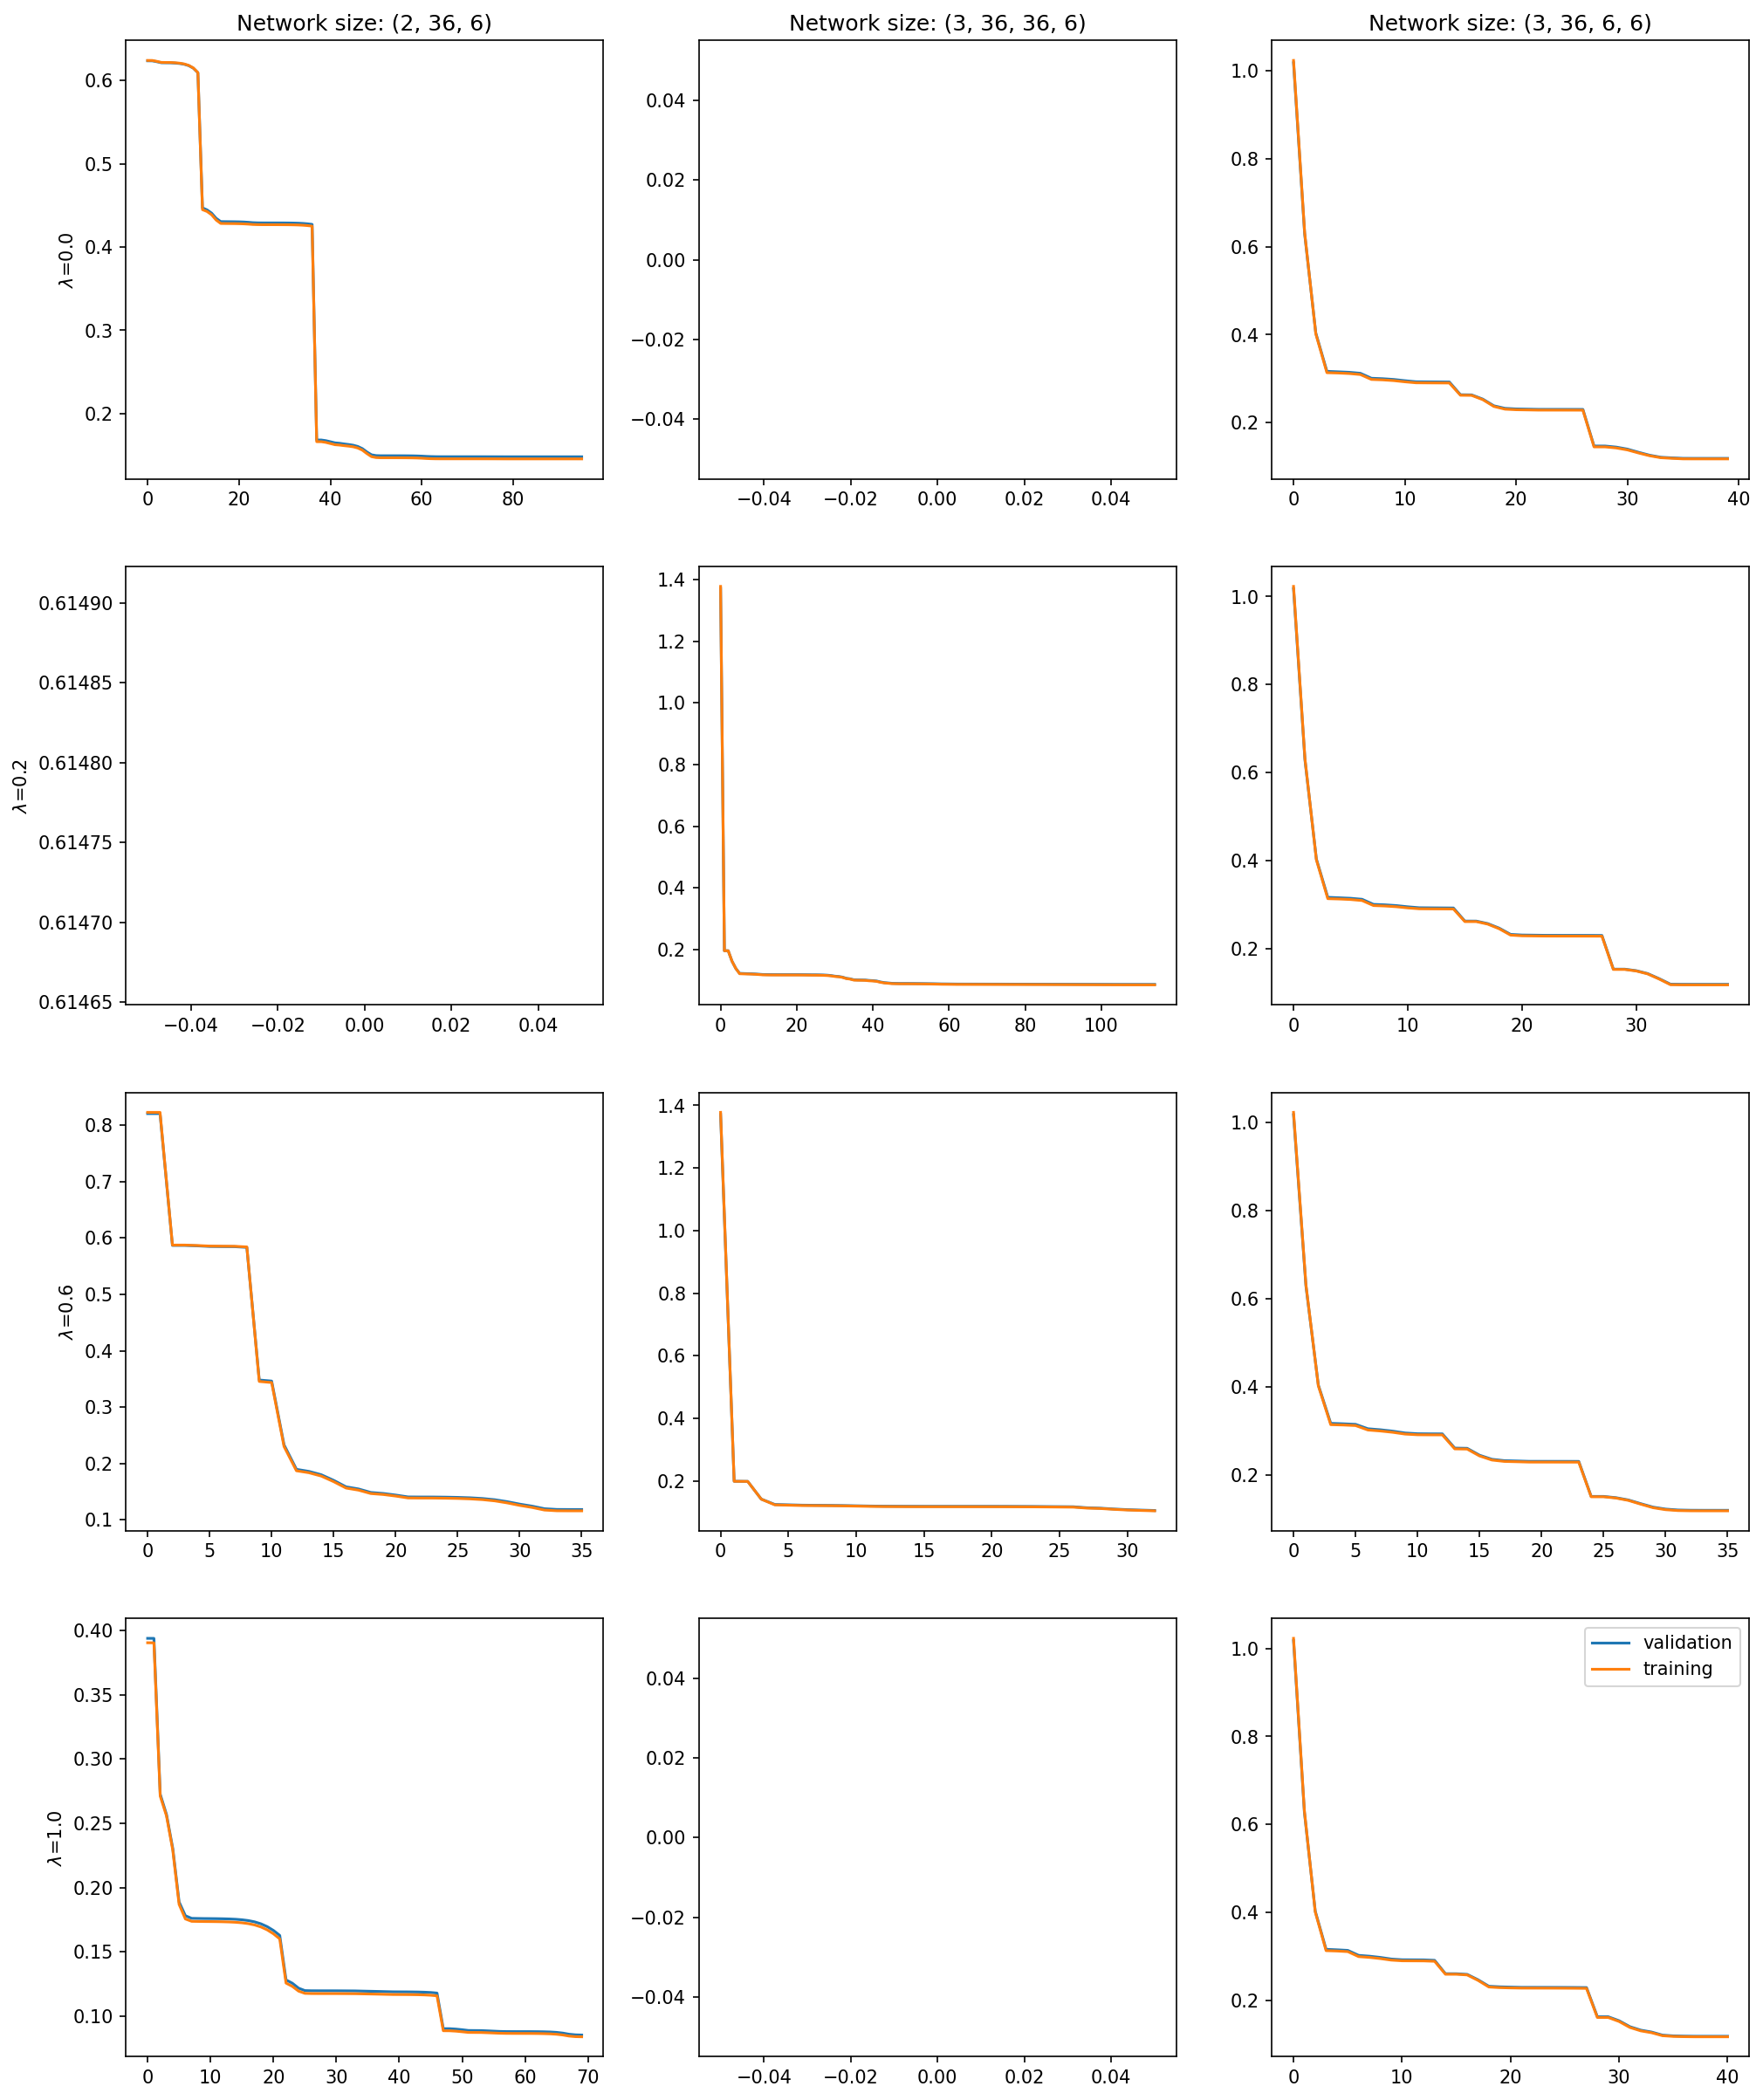

In [8]:
#Plot only every 4th regularisation value trained to keep track of plots
#The shape of plots remain somewhat similar amongst different regularisation parameter values.
regularisations_to_plot = regularisations[::4] 
column_args = network_sizes[:3]
fig, axs = plt.subplots( nrows=len(regularisations_to_plot), ncols=len(column_args), figsize=(16,20), dpi=150 )
for k, reg in enumerate(regularisations_to_plot):
    for j, arg in enumerate(column_args):
        no_layers = arg[0]
        nodes_per_layer = list( arg[1:] )
        training_loss, validation_loss = get_training_validation_loss(no_layers=no_layers, 
                                                                        nodes_per_layer=nodes_per_layer,
                                                                        reg=reg,
                                                                        x_valid=x_valid,
                                                                        y_valid=y_valid
                                                                        )
        axs[k, j].plot( validation_loss, label = "validation" )
        axs[k, j].plot( training_loss, label = "training" )
        if j == 0:
            axs[k, j].set_ylabel("$\lambda$={}".format(reg))
        if k == 0:
            axs[k, j].set_title("Network size: {}".format(arg))
        
axs[k,j].legend()
plt.show()

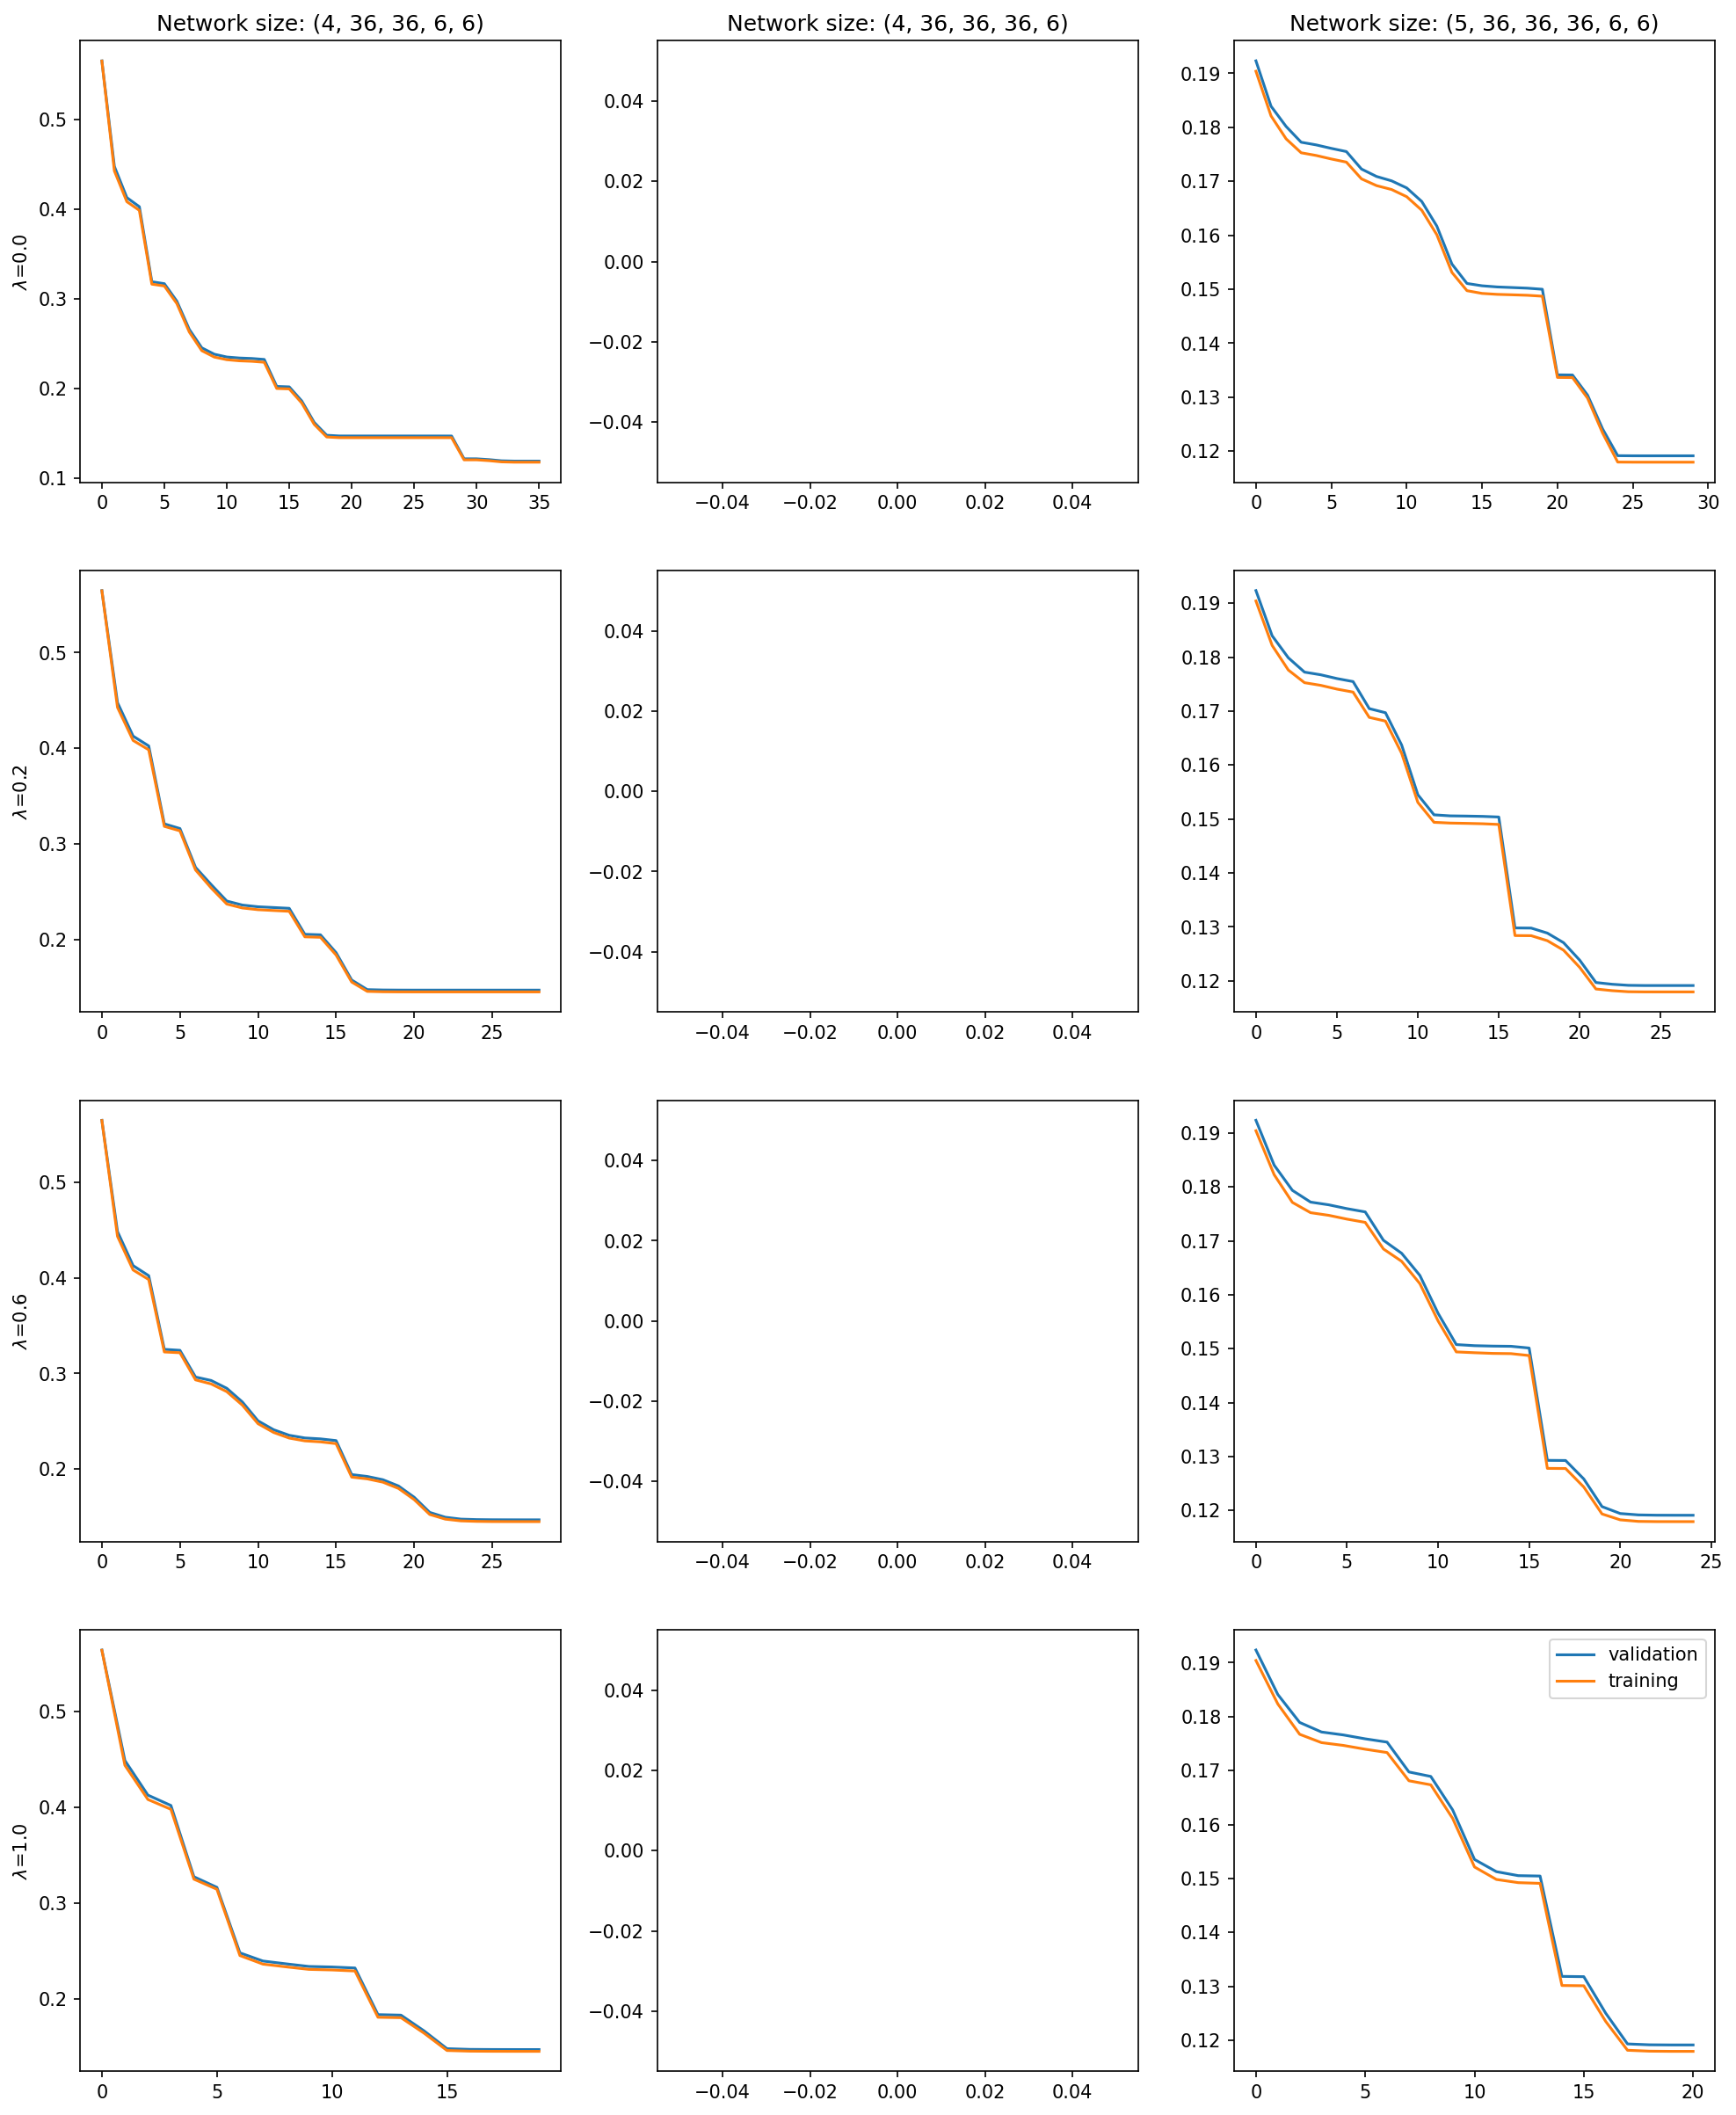

In [9]:
#More plots like above, but for different network sizes
regularisations_to_plot = regularisations[::4]
column_args = network_sizes[3:]
fig, axs = plt.subplots( nrows=len(regularisations_to_plot), ncols=len(column_args), figsize=(16,20), dpi=150 )
for k, reg in enumerate(regularisations_to_plot):
    for j, arg in enumerate(column_args):
        no_layers = arg[0]
        nodes_per_layer = list( arg[1:] )
        training_loss, validation_loss = get_training_validation_loss(no_layers=no_layers, 
                                                                        nodes_per_layer=nodes_per_layer,
                                                                        reg=reg,
                                                                        x_valid=x_valid,
                                                                        y_valid=y_valid
                                                                        )
        axs[k, j].plot( validation_loss, label = "validation" )
        axs[k, j].plot( training_loss, label = "training" )
        if j == 0:
            axs[k, j].set_ylabel("$\lambda$={}".format(reg))
        if k == 0:
            axs[k, j].set_title("Network size: {}".format(arg))
        
axs[k,j].legend()
plt.show()

Empty plots likely indicate flat gradients which is not great for gradient-based training.  
A trained network is shown below where we see that the training begun and ended at 0 epochs, despite 10 random initialisations of network weights.  
The vanishing gradient of the network weights is demonstrated as well, or in other words, the plateau of the weights landscape.   

In [10]:
reg = 1.0
no_layers = 4
nodes_per_layer = [36, 36, 36, 6]
network_data = access_trainednetwork(no_layers=no_layers, nodes_per_layer=nodes_per_layer, regularisation=reg)
print( "lambda={}, nodes={}\nNo. epochs: {}\nLoss: {}".format( reg, nodes_per_layer, network_data["n_epochs"], network_data["loss"] ) )

network_weights = reshape_weights( np.asarray( network_data["weights"], np.float128) , nodes_per_layer )
print( "\nAverage gradient at each layer: ")
grad = gradient(network_weights, x=x_train, y=y_train) 
for k in range(no_layers-1):
    wt = grad[k]
    print( "Layer {} average gradient: {}".format(k+1, np.mean(wt)) )

lambda=1.0, nodes=[36, 36, 36, 6]
No. epochs: 0
Loss: 1.3777179099834793

Average gradient at each layer: 
Layer 1 average gradient: 4.553374768512191e-18
Layer 2 average gradient: 7.578084451607042e-15
Layer 3 average gradient: 9.413415554739075e-08


To see the flatness(plateau) of the network weights landscape, we see the training error stays constant and the gradient is still 0 at a randomly initialised point.

In [11]:
rng = np.random.default_rng(61975)
rand_weights = rng.random( size = (len(network_data["weights"]),) )
rand_weights = reshape_weights( rand_weights.astype(np.float128), nodes_per_layer )
print("Loss: {}".format(cost_network(rand_weights, x_train, y_train)) )
grad = gradient(rand_weights, x=x_train, y=y_train)
print("\nAverage gradient at each layer: ")
for k in range(no_layers-1):
    wt = grad[k]
    print( "Layer {} average gradient: {}".format(k+1, np.mean(wt)) )


Loss: 1.3777182509027237

Average gradient at each layer: 
Layer 1 average gradient: 1.3317158008433e-18
Layer 2 average gradient: 2.9735033790764376e-15
Layer 3 average gradient: 3.7314328347597034e-08



Training loss is generally high when plateau occurs, like above.  
This is likely indicating underfitting and by decreasing regularisation we get a much lower loss.  

In [12]:
reg = 0.2
no_layers = 4
nodes_per_layer = [36, 36, 36, 6]
network_data = access_trainednetwork(no_layers=no_layers, nodes_per_layer=nodes_per_layer, regularisation=reg)
print( "lambda={}, nodes={}\nNo. epochs: {}\nLoss: {}".format( reg, nodes_per_layer, network_data["n_epochs"], network_data["loss"] ) )

network_weights = reshape_weights( np.asarray( network_data["weights"], np.float128) , nodes_per_layer )
print( "\nAverage gradient at each layer: ")
grad = gradient(network_weights, x=x_train, y=y_train) 
for k in range(no_layers-1):
    wt = grad[k]
    print( "Layer {} average gradient: {}".format(k+1, np.mean(wt)) )

lambda=0.2, nodes=[36, 36, 36, 6]
No. epochs: 81
Loss: 0.08195241502114006

Average gradient at each layer: 
Layer 1 average gradient: -6.923641556002353e-05
Layer 2 average gradient: 2.923735783475809e-05
Layer 3 average gradient: -6.670880254035111e-05


## QAOA performance using predictions from network
We use the network with the lowest validation loss.

In [9]:
#Find the network with the lowest validation loss.
best_network = None
best_networksize = None
lowest_error = float('inf')
lowest_reg = None
for network_size, networks in trained_networks.items():
    nodes_per_layer = list( network_size[1:] )
    for reg, network in networks.items():
        network_weights = np.asarray( network["weights"], dtype=np.float128 )
        network_weights = reshape_weights( network_weights, nodes_per_layer )
        network_err = cost_network( network_weights, x_valid, y_valid )
        if network_err < lowest_error:
            lowest_error = network_err
            best_network = network_weights
            best_networksize = network_size
            lowest_reg = reg


In [10]:
print("Best network size: {}".format( best_networksize ) )
print("Regularisation used: {}".format( lowest_reg ) )
print("Best network error on validation set: {}".format( lowest_error ) )

Best network size: (4, 36, 36, 36, 6)
Regularisation used: 0.2
Best network error on validation set: 0.08327586690495604


In [11]:
#Generate a new QAOA instance not from training or validation set
import networkx as nx
import json
from generate_ising import generate_ising_array
from scipy.optimize import minimize
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, Parameter
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Statevector, Pauli

def qaoa_circuit(ising_hamiltonian, p=1):
    N = ising_hamiltonian.shape[0]
    gammas = ParameterVector("γ", length=p)
    betas = ParameterVector("β", length=p)
    qaoa_circ = QuantumCircuit(N)
    qaoa_circ.h(range(N))
    for k in range(p):
        add_isingqaoa_layer(qaoa_circ, ising_hamiltonian, gammas[k], betas[k])
    return qaoa_circ, betas, gammas

def add_isingqaoa_layer(qc, ising_hamiltonian, gamma, beta):
    N = ising_hamiltonian.shape[0]
    for i in range(N):
        qc.rz(2*gamma*ising_hamiltonian[i,i], i)
    for i in range(N):
        for j in range(i+1, N):
            qc.cx(i,j)
            qc.rz(2*gamma*ising_hamiltonian[i,j], j)
            qc.cx(i,j)
    qc.rx(2*beta, range(N))

def qiskit_isingop_from_J(J, N):
    ops = []
    for i in range(N):
        for j in range(i+1, N):
            op = ["I"]*N
            op[i] = "Z"
            op[j] = "Z"
            pauli_str = "".join(op)
            if np.abs(J[i,j]) > 1e-6:
                pauli = PauliOp(Pauli( pauli_str[::-1] ), coeff=J[i,j] )
                ops += [pauli]
    op = sum(ops)
    return op


/home/jvillanueva/.local/lib/python3.9/site-packages/qiskit/version.py:20: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Defining a function that returns an instance dependent metric from 0 to 1 that indicate the performance of QAOA parameters.  
A value of 1 indicates best performance, and 0 indicates worst performance. In other words, HIGHER values mean BETTER performance.  

In [12]:
def get_rq(J, params, qaoa_layers=3):
    p = qaoa_layers
    qaoa_qc, _, _ = qaoa_circuit(ising_hamiltonian = J, p=p)
    ising_op = qiskit_isingop_from_J(J, N)
    ising_matrixop = ising_op.to_matrix(massive=False).diagonal().real
    min_E, max_E = ising_matrixop.min(), ising_matrixop.max()
    def qaoa_expectation( params ):
        sv = Statevector( qaoa_qc.assign_parameters(params) ).data
        return np.dot( np.conj(sv), ising_matrixop * sv).real
    exp = qaoa_expectation(params)
    return (max_E - exp) / (max_E - min_E)

In [13]:
#Need to use normalisation data to normalise inputs and de-normalise outputs.
xmins = np.loadtxt("datasets/xmins.csv", delimiter=",")
xminmaxrange = np.loadtxt("datasets/xminmaxrange.csv", delimiter=",")
ymins = np.loadtxt("datasets/ymins.csv", delimiter=",")
yminmaxrange = np.loadtxt("datasets/yminmaxrange.csv", delimiter=",")

In [14]:
#Function that returns predicted angles from network for a list of Hamiltonian arrays stored in the list J_s.
def predict_angles( J_s ):
    x_inputs = np.zeros( (36, len(J_s)) )
    for s in range(len(J_s)):
        J = J_s[s]
        x = J[ np.triu_indices(N, k=1) ]
        x_inputs[:, s] = x
    #Normalise x:
    xmins_stacked = np.broadcast_to(xmins, (len(J_s),)+xmins.shape).T
    xminmaxrange_stacked = np.broadcast_to(xminmaxrange, (len(J_s),)+xminmaxrange.shape).T
    ymins_stacked = np.broadcast_to(ymins, (len(J_s),)+ymins.shape).T
    yminmaxrange_stacked = np.broadcast_to(yminmaxrange, (len(J_s),)+yminmaxrange.shape).T
    x_inputs -= xmins_stacked
    x_inputs /= xminmaxrange_stacked
    
    #Forward pass to network and denormalise y
    y = forward_pass(best_network, x=x_inputs)
    y *= yminmaxrange_stacked
    y += ymins_stacked

    #Turn gammas back into negative values:
    y[3:, :] *= -1

    return y

In [15]:
# Generate 8 new Hamiltonian/QAOA instances,
# Vary the probability of edge being created in QAOA Hamiltonian from 0.1 to 0.9
# Note: Training and validation datasets only included prob_edge = 0.3 and 0.7.
N=9
J_s = [ None for _ in range(8) ] 
rng = np.random.default_rng(78628)
seeds = rng.integers(1000, size=8, dtype=int)
seeds = [int(x) for x in seeds]
J_s[0], _ = generate_ising_array(N, prob_edge=0.3, weighted=True, seed=seeds[0])
J_s[1], _ = generate_ising_array(N, prob_edge=0.5, weighted=True, seed=seeds[1])
J_s[2], _ = generate_ising_array(N, prob_edge=0.7, weighted=True, seed=seeds[2])
J_s[3], _ = generate_ising_array(N, prob_edge=0.3, weighted=False, seed=seeds[3])
J_s[4], _ = generate_ising_array(N, prob_edge=0.5, weighted=False, seed=seeds[4])
J_s[5], _ = generate_ising_array(N, prob_edge=0.7, weighted=False, seed=seeds[5])
J_s[6], _ = generate_ising_array(N, prob_edge=0.9, weighted=True, seed=seeds[6])
J_s[7], _ = generate_ising_array(N, prob_edge=0.1, weighted=True, seed=seeds[7])

In [24]:
print("Predicted angles:")
angles = predict_angles(J_s)
for s in range(8):
    print("Instance {}: ".format(s+1), angles[:, s])

Predicted angles:
Instance 1:  [ 0.56  0.38  0.21 -0.21 -0.4  -0.44]
Instance 2:  [ 0.57  0.38  0.21 -0.21 -0.4  -0.45]
Instance 3:  [ 0.59  0.39  0.21 -0.22 -0.42 -0.46]
Instance 4:  [ 0.5   0.34  0.2  -0.18 -0.36 -0.41]
Instance 5:  [ 0.48  0.34  0.2  -0.18 -0.35 -0.4 ]
Instance 6:  [ 0.42  0.31  0.19 -0.16 -0.32 -0.37]
Instance 7:  [ 0.54  0.36  0.2  -0.2  -0.38 -0.43]
Instance 8:  [ 0.56  0.37  0.21 -0.21 -0.4  -0.44]


In [23]:
print("Performance using predicted angles:")
predictions = []
for s in range(8):
    r_q = get_rq(J_s[s], params=angles[:, s])
    predictions += [r_q]
    print("Instance {}: ".format(s+1), r_q)

Performance using predicted angles:
Instance 1:  0.8673113391545676
Instance 2:  0.887647958172158
Instance 3:  0.8636624694008156
Instance 4:  0.9021421036560392
Instance 5:  0.933354537919801
Instance 6:  0.9340174179133572
Instance 7:  0.6653397493259732
Instance 8:  0.8571054326579773


On paper, performance looks decent (except perhaps for instance 7 with prob_edge=0.9) but metric is likely biased because of the chosen output range defined by ymins and yminmaxrange.  
To get around this, we compare the predicted performance with that of randomly guessing outputs from this output range.  

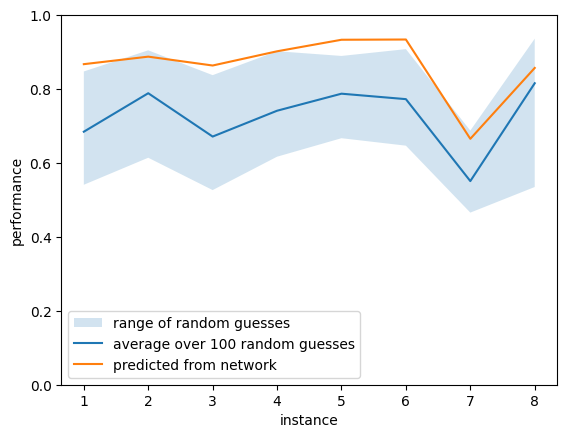

In [26]:
rng = np.random.default_rng(92311)
r_qs = np.zeros( (8, 100) )
for s in range(8):
    #100 random QAOA angles for each of the instance
    random_ys = rng.random( size=(6, 100) ) 

    #Stack the normalising array to match shape of random angle array
    ymins_stacked = np.broadcast_to(ymins, (100,6)).T
    yminmaxrange_stacked = np.broadcast_to(yminmaxrange, (100,6)).T

    #Denormalise random angles
    random_ys *= yminmaxrange_stacked
    random_ys += ymins_stacked
    random_ys[3:, :] *= -1

    #Now get performance of each random angle for each QAOA instance.
    J = J_s[s]
    for t in range(100):
        params = random_ys[:,t]
        r_q = get_rq(J, params)
        r_qs[s,t] = r_q

#Plot
fig, ax = plt.subplots()
ax.fill_between( x = np.arange(1,9), y1 = np.min(r_qs, axis=1), y2 = np.max(r_qs, axis=1), alpha = 0.2, label="range of random guesses" )
ax.plot( np.arange(1,9), np.mean(r_qs, axis=1), label = "average over 100 random guesses")
ax.plot( np.arange(1,9), predictions, label = "predicted from network")
ax.set_ylabel("performance")
ax.set_xlabel("instance")
ax.set_ylim(0,1)
ax.legend()
fig.show()

## Summary of neural network performance on predicting QAOA angles

It is clear from the last plot that predicted angles from the network provides a performance benefit against random guessing.

But from the plots of the training vs validation loss against epochs (even without hidden layers), this type of network is generalising too easily.  
From intuition, this tells me that the neural network approach is probably overcomplicating the problem of predicting angles!  
In particular, I ignore the well-studied phenomenon that QAOA performance occurs over a family of QAOA instances.  
If I were to use this concentration phenomenon for an updated version of the network, I could instead use different features that classify the family that the instance belongs to instead.
E.g. the probability of the edge creation instead. This could also be more useful in making the inputs size independent, since the inputs for the networks here only worked for N=9 qubits. 
 This potentially has practical implications for the QAOA algorithm, since better feature selection could allow for training on small (thus, simulable!) QAOA instances.